This is a step by step tutorial on time series analysis a forecasting. I am going to illustrate the use of TS analysis on the dataset from "Store Item Demand Forecast Challenge" and show how to use the different TS forecasting models, specifically : I'm going to show:
* Playing with TS and time/date information in pandas
* TS Decomposition
* Forecast :
 1. Moving average
 2. Prophet
 3. ARIMA 
 
 ## Load data & display basic statistics

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test.csv', 'train.csv']


In [2]:
df_train = pd.read_csv('../input/train.csv', parse_dates=['date'], index_col=['date'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
store    913000 non-null int64
item     913000 non-null int64
sales    913000 non-null int64
dtypes: int64(3)
memory usage: 27.9 MB


## Check & decompose seasonality

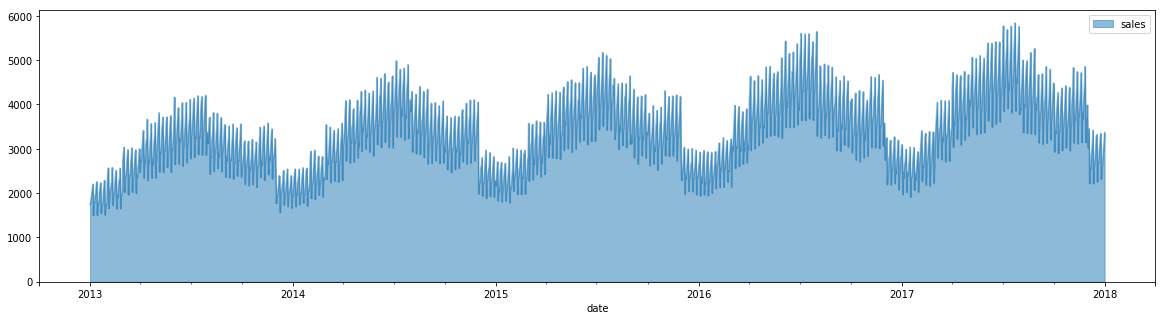

In [3]:
# choose one stroe to test with
sales2 = df_train[df_train.store == 2]['sales'].sort_index(ascending = True)

# the target var must be float type
df_train['sales'] = df_train['sales'].astype('float32')

# plot the total amount of sales, per day
sales2 = sales2.resample('D').sum()
sales2.plot(kind='area', figsize=(20,5), legend=True, alpha=.5)

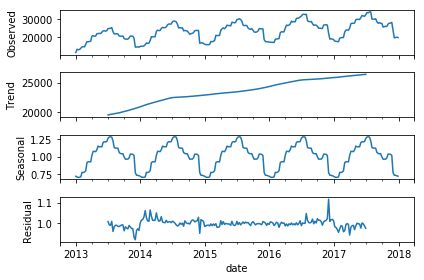

In [4]:
# check for seasonality
import statsmodels.api as sm

# freq=the number of batches per period (year), if we use a weekly granularity, then freq=52
dec_a = sm.tsa.seasonal_decompose(sales2.resample('W').sum(), model = 'multiplicative', freq = 52)
dec_a.plot().show()

The trend is then unstable (going up), in addition to the obvious seasonality (peak in the mid of year).

## Moving average

plot the observed vs estimated values

In [5]:
# use a rolling window and compute mean on the last "window" values (varied)
sales2_est30d = sales2.rolling(window=30).mean()
sales2_est60d = sales2.rolling(window=60).mean()
sales2_est90d = sales2.rolling(window=90).mean()

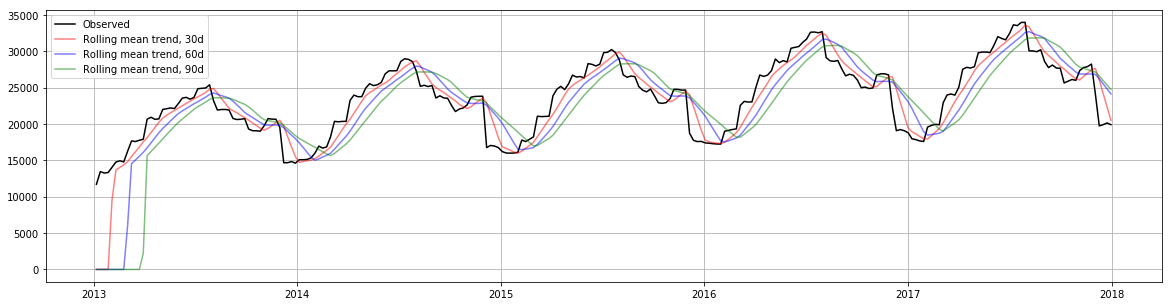

In [6]:
import matplotlib.pyplot as plt

# plot the week by week values: observed vs estimated for different values of window
plt.figure(figsize=(20, 5))
plt.plot(sales2.resample('W').sum(), color='Black', label="Observed", alpha=1)
plt.plot(sales2_est30d.resample('W').sum(), color='Red', label="Rolling mean trend, 30d", alpha=.5)
plt.plot(sales2_est60d.resample('W').sum(), color='Blue', label="Rolling mean trend, 60d", alpha=.5)
plt.plot(sales2_est90d.resample('W').sum(), color='Green', label="Rolling mean trend, 90d", alpha=.5)
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

We observe that the rolling mean (aka moving average) is a good estimator. The 90d model takes more time to capture the trend, whereas the sortest models are the best estimetors. Indeed, a 1-day average model it is generally an excellent baseline, sometimes impossible to beat. 

## Prophet

In [13]:
# import Prophet 
from fbprophet import Prophet

# reformat data
s = sales2.reset_index()
s.columns = ['ds', 'y']
s.head()

,ds,y
0,2013-01-01,1742
1,2013-01-02,1808
2,2013-01-03,1887
3,2013-01-04,1983
4,2013-01-05,2087


In [14]:
# fit a Prohet model. We assume there is no daily seasonality (or not interested in)
proph = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
proph.fit(s[['ds','y']])

In [15]:
# make a void dataframe with future timestamps then compute predictions for it
fut = proph.make_future_dataframe(include_history=False, periods=12, freq = 'm') # 12 months
forecast = proph.predict(fut)

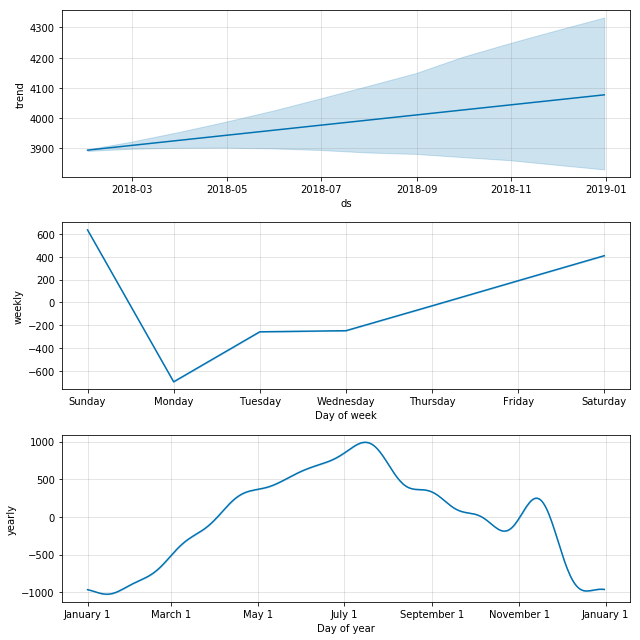

In [18]:
# plot all resulting components
proph.plot_components(forecast).show()

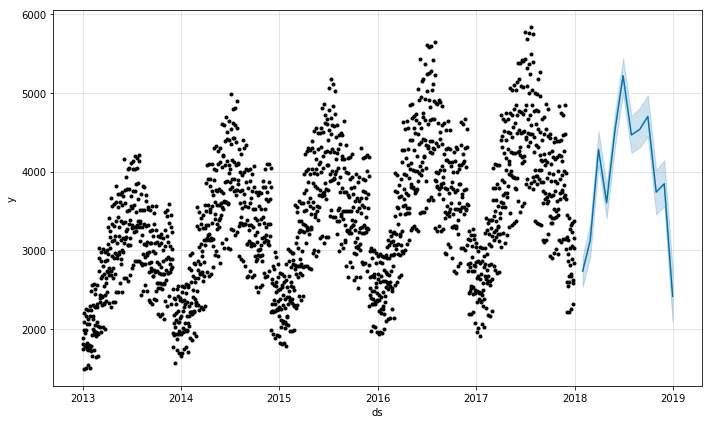

In [19]:
# another way to plot results
proph.plot(forecast).show()

## ARIMA

In [20]:
sales2.head()

date
2013-01-01    1742
2013-01-02    1808
2013-01-03    1887
2013-01-04    1983
2013-01-05    2087
Freq: D, Name: sales, dtype: int64

Check the autocorrelation within the TS, will help fixing the 1st parameter p for ARIMA

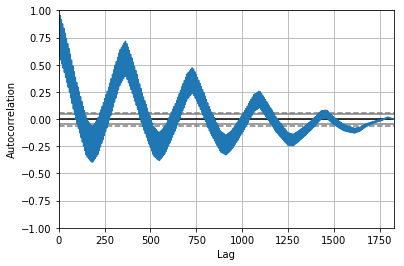

In [21]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(sales2)

The first 100 lags seems to be significantly correlated to the current value. A good starting point may be fixing p=100

In [60]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

arim = ARIMA(sales2, order=(10,1,0)) # order=(p,d,q); p:AR param, d:differencing degree, q:windw size of MA
model_fit = arim.fit(disp=0)

/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

In [61]:
#print(model_fit.summary())

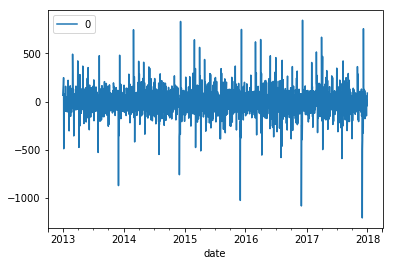

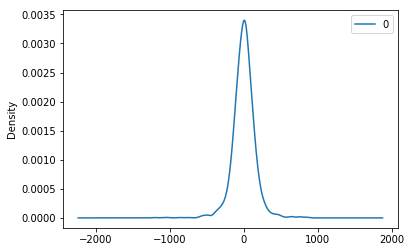

In [62]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
# resid error density
residuals.plot.kde()

In [63]:
# generate a dateframe to forecast for
fut

,ds
0,2018-01-31
1,2018-02-28
2,2018-03-31
3,2018-04-30
4,2018-05-31
5,2018-06-30
6,2018-07-31
7,2018-08-31
8,2018-09-30
9,2018-10-31


In [64]:
# forecast
n_to_predict = 365
pred, err, bounds = model_fit.forecast(steps=n_to_predict) # predict for all dataset

In [65]:
from matplotlib.pyplot import plot
df = pd.DataFrame({'pred':pred})

In [66]:
full_df = pd.Series(pred.tolist(), index=pd.date_range('2018-01-01', freq='d', periods=n_to_predict).tolist())
full_df = sales2.append(full_df)

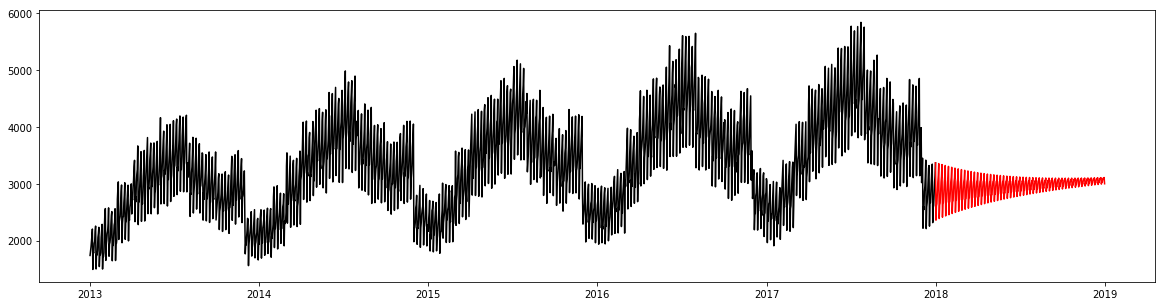

In [67]:
n = full_df.shape[0] - n_to_predict
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(full_df[0:n], color='Black')
ax.plot(full_df[n-1:full_df.shape[0]], color='Red')
plt.show()

Predictions are not good. Ain't more time to investigate why...